# OpenCV

## 이미지 데이터 구조의 이해

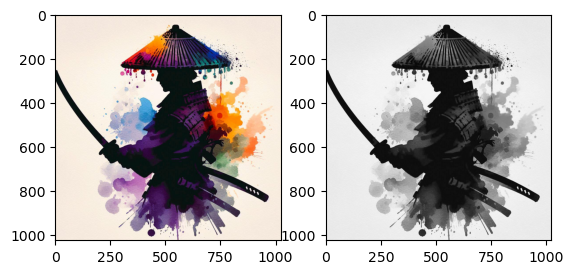

In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

color_img = np.asarray(Image.open('assets/color.jpg'))
gray_img = np.mean(color_img, axis=2).astype(np.uint8)
fig, ax = plt.subplots(ncols=2)
ax[0].imshow(color_img)
ax[1].imshow(gray_img, cmap='gray')

## OpenCV vs Pillow
- 요약: OpenCV가 빠르다.

## 크기 조절

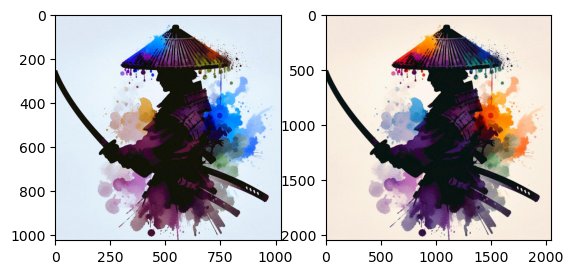

In [3]:
import cv2
import matplotlib.pyplot as plt
img = cv2.imread('assets/color.jpg')
img2 = cv2.resize(img, None, fx=2, fy=2)
fig, ax = plt.subplots(ncols=2)
ax[0].imshow(img)
ax[1].imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))

## 회전

`rotate(src, rotateCode[,dst])`



In [10]:
import cv2
import numpy as np

# 원본 이미지
img = cv2.imread('assets/sample.jpg')

# 이미지 중심 좌표
# shape에선 height 먼저 나온다
(h, w) = img.shape[:2]
center = (w // 2, h // 2)

# 회전 행렬 (45도 회전 + 0.5배 확대)
# 이미지 변경방법을 행렬을 통해 표현하고, 이 행렬을 warpAffine에 넣는다.
M = cv2.getRotationMatrix2D(center=center, angle=45, scale=0.5)

# Affine 변환 적용
rotated = cv2.warpAffine(img, M, (w, h))

# 출력
cv2.imshow('Rotated Image', rotated)
cv2.waitKey(0)
cv2.destroyAllWindows()


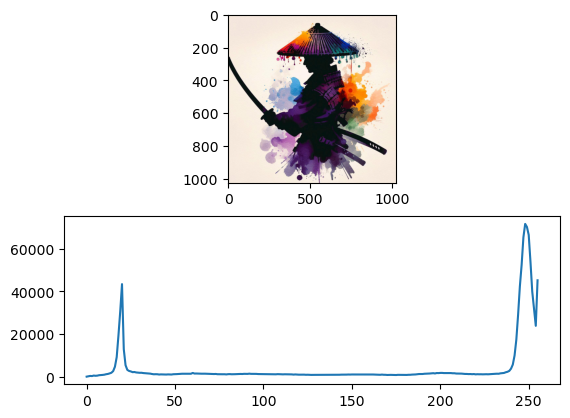

In [15]:
import cv2
import matplotlib.pyplot as plt

def show_histogram(hsv):
    h,s,v = cv2.split(hsv)
    hist = cv2.calcHist([v], [0], None, [256], [0, 256])
    ax = plt.subplot(2,1,2)
    ax.plot(hist)
    ax = plt.subplot(2,1,1)
    ax.imshow(cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB))
    plt.show()
    
img = cv2.imread('assets/color.jpg')
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
show_histogram(hsv)

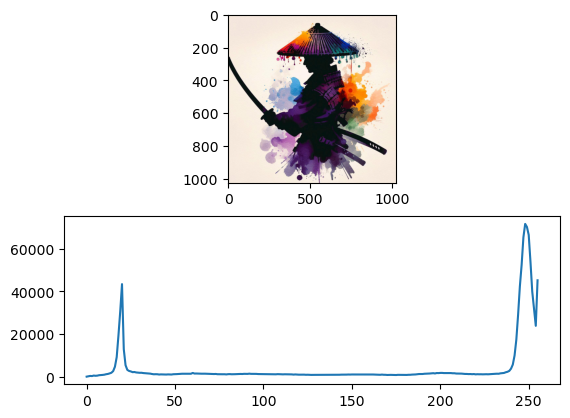

In [16]:
h,s,v = cv2.split(hsv)
v_norm= cv2.normalize(v, None, 0, 255, cv2.NORM_MINMAX)
hsv_norm = cv2.merge((h,s,v_norm))
show_histogram(hsv_norm)

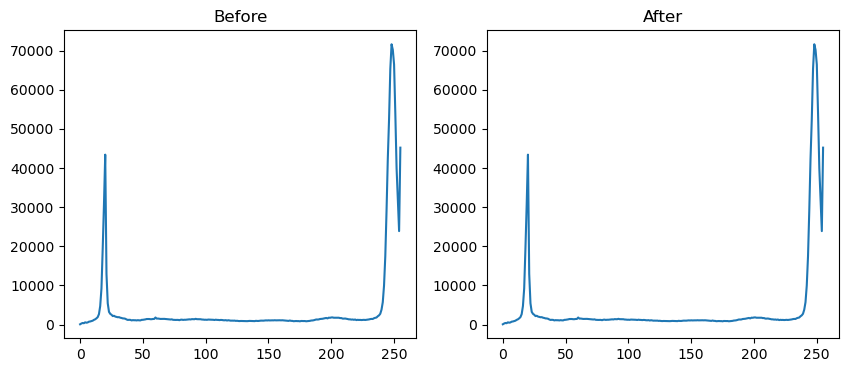

In [20]:
import cv2
import matplotlib.pyplot as plt

img = cv2.imread('assets/color.jpg')
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
h, s, v = cv2.split(hsv)

# 정규화
v_norm = cv2.normalize(v, None, 0, 255, cv2.NORM_MINMAX)
hsv_norm = cv2.merge((h, s, v_norm))

# 히스토그램 확인 함수
def show_histogram(v_before, v_after):
    hist1 = cv2.calcHist([v_before], [0], None, [256], [0, 256])
    hist2 = cv2.calcHist([v_after], [0], None, [256], [0, 256])
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1); plt.plot(hist1); plt.title('Before')
    plt.subplot(1,2,2); plt.plot(hist2); plt.title('After')
    plt.show()

show_histogram(v, v_norm)


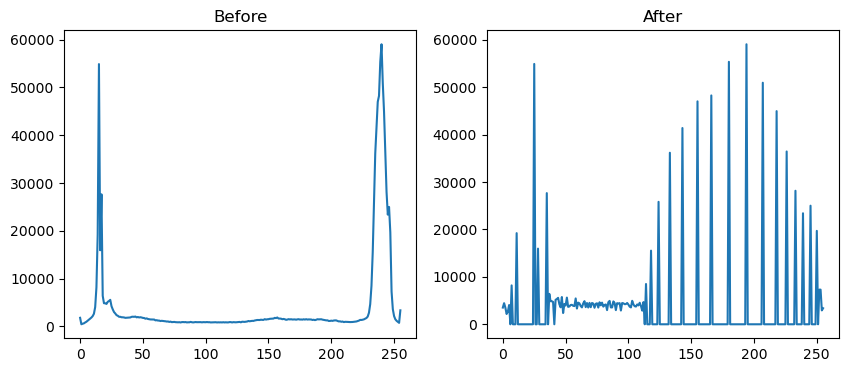

In [22]:
img = cv2.imread('assets/color.jpg', cv2.IMREAD_GRAYSCALE)
img_equalized = cv2.equalizeHist(img)   

hist = cv2.calcHist([img], [0], None, [256], [0, 256])
hist_equalized = cv2.calcHist([img_equalized], [0], None, [256], [0, 256])

plt.figure(figsize=(10,4))
for i, h in enumerate([hist, hist_equalized]):
    plt.subplot(1,2,i+1)
    plt.plot(h)
    plt.title('Before' if i == 0 else 'After')
plt.show()
cv2.imshow('Original Grayscale', img)
cv2.imshow('Equalized Grayscale', img_equalized)
cv2.waitKey(0)
cv2.destroyAllWindows()

### 실습


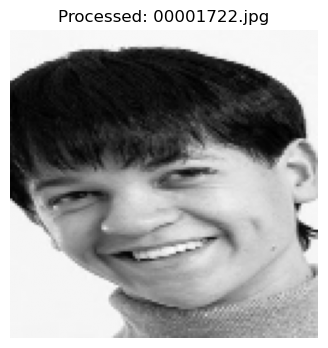

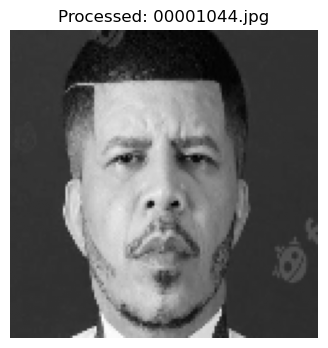

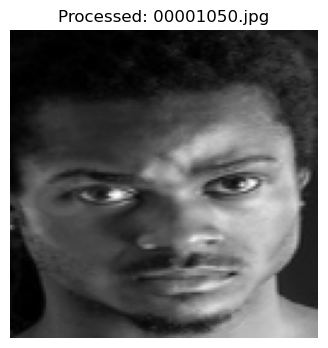

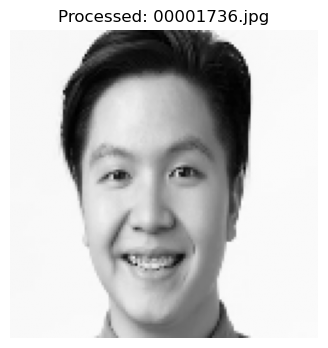

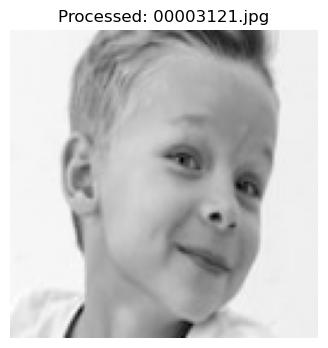

✅ 전처리 완료.


In [1]:
import cv2
import pandas as pd
import os
import matplotlib.pyplot as plt

# 1. 경로 설정
csv_path = "./faces.csv"
image_folder = "./assets"
target_size = (128, 128)

# 2. CSV 데이터 불러오기
df = pd.read_csv(csv_path)

# 3. 전처리 반복 적용
for idx, row in df.iterrows():
    image_path = os.path.join(image_folder, row['image_name'])
    
    # 이미지 로드
    img = cv2.imread(image_path)
    if img is None:
        print(f"❌ 이미지 로드 실패: {row['image_name']}")
        continue

    height, width = img.shape[:2]

    # 얼굴 좌표 가져오기 및 유효 범위 보정
    x0 = max(0, min(width, int(row['x0'])))
    y0 = max(0, min(height, int(row['y0'])))
    x1 = max(0, min(width, int(row['x1'])))
    y1 = max(0, min(height, int(row['y1'])))

    # 좌표 유효성 확인
    if x1 <= x0 or y1 <= y0:
        print(f"⚠️ 잘못된 좌표: {row['image_name']} → ({x0},{y0}) to ({x1},{y1})")
        continue

    # 얼굴 영역 자르기
    face = img[y0:y1, x0:x1]

    # 크기 조절
    try:
        resized_face = cv2.resize(face, target_size, interpolation=cv2.INTER_LINEAR)
    except Exception as e:
        print(f"⚠️ 크기 조절 오류: {row['image_name']} → {e}")
        continue

    # 흑백 변환
    gray_face = cv2.cvtColor(resized_face, cv2.COLOR_BGR2GRAY)

    # 시각화 (처음 5개만 표시)
    if idx < 5:
        plt.figure(figsize=(4, 4))
        plt.imshow(gray_face, cmap='gray')
        plt.title(f"Processed: {row['image_name']}")
        plt.axis('off')
        plt.show()

    # (선택) 저장
    save_path = f"./processed/{os.path.splitext(row['image_name'])[0]}_gray.png"
    os.makedirs("./processed", exist_ok=True)
    cv2.imwrite(save_path, gray_face)

print("✅ 전처리 완료.")


In [1]:
import cv2
import pandas as pd
import os
import matplotlib.pyplot as plt

# 경로 설정
csv_path = "./faces.csv"
image_folder = "./assets"
target_size = (128, 128)
save_folder = "./processed2"
os.makedirs(save_folder, exist_ok=True)

# CSV 불러오기
df = pd.read_csv(csv_path)

# 이미지별 그룹 처리
grouped = df.groupby("image_name")

for image_name, group in grouped:
    image_path = os.path.join(image_folder, image_name)
    img = cv2.imread(image_path)

    if img is None:
        print(f"❌ 이미지 로드 실패: {image_name}")
        continue

    height, width = img.shape[:2]

    for i, row in group.iterrows():
        # 좌표 추출 및 보정
        x0 = max(0, min(width, int(row['x0'])))
        y0 = max(0, min(height, int(row['y0'])))
        x1 = max(0, min(width, int(row['x1'])))
        y1 = max(0, min(height, int(row['y1'])))

        if x1 <= x0 or y1 <= y0:
            print(f"⚠️ 잘못된 좌표: {image_name} → ({x0},{y0}) to ({x1},{y1})")
            continue

        # 얼굴 자르기 → 크기 조정 → 흑백 변환
        face = img[y0:y1, x0:x1]
        try:
            resized_face = cv2.resize(face, target_size)
            gray_face = cv2.cvtColor(resized_face, cv2.COLOR_BGR2GRAY)
        except Exception as e:
            print(f"⚠️ 처리 오류: {image_name} - 얼굴 {i} → {e}")
            continue

        # 시각화 (처음 몇 개만)
        if i < 2 and grouped.ngroups < 3:
            plt.figure(figsize=(3, 3))
            plt.imshow(gray_face, cmap='gray')
            plt.title(f"{image_name} - Face {i}")
            plt.axis('off')
            plt.show()

        # 저장
        save_path = os.path.join(save_folder, f"{os.path.splitext(image_name)[0]}_face{i}.png")
        cv2.imwrite(save_path, gray_face)

print("✅ 다중 얼굴 처리 완료.")


✅ 다중 얼굴 처리 완료.


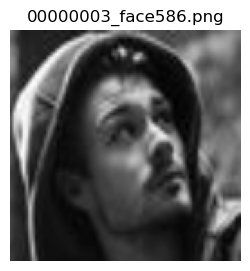

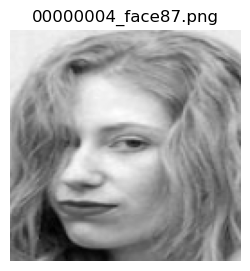

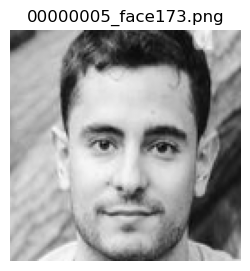

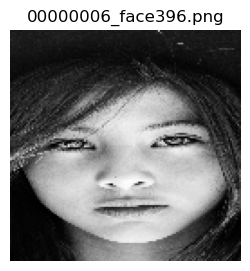

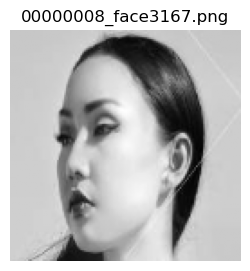

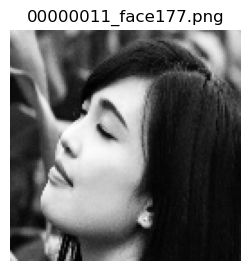

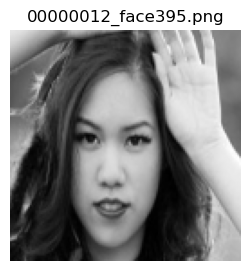

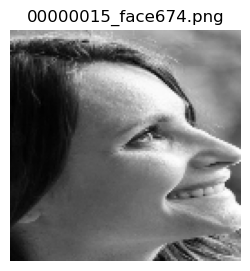

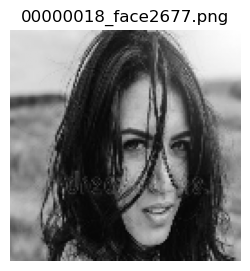

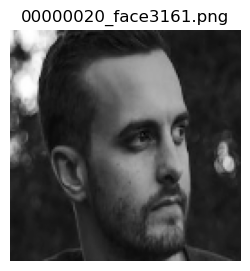

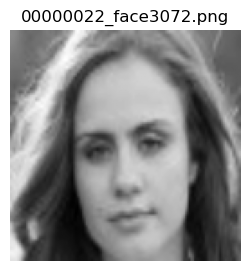

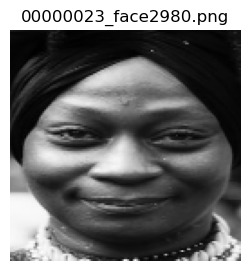

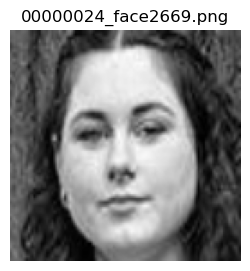

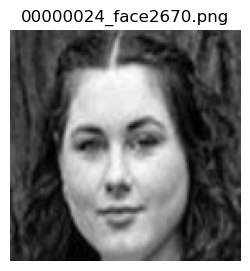

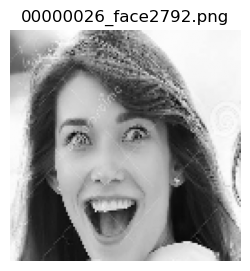

In [4]:
import cv2
import os
import matplotlib.pyplot as plt

image_folder = './processed2'
image_files = [f for f in os.listdir(image_folder) if f.endswith(('.jpg', '.png', '.jpeg'))]

# 이미지 반복 불러오기
for idx, filename in enumerate(image_files[:15]):  # 예: 처음 10장만 보기
    img_path = os.path.join(image_folder, filename)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # 흑백일 경우

    if img is None:
        print(f"❌ 불러오기 실패: {filename}")
        continue

    # 시각화
    plt.figure(figsize=(3, 3))
    plt.imshow(img, cmap='gray')
    plt.title(filename)
    plt.axis('off')
    plt.show()

파일: 00003320_face256.png
평균: 165.39, 표준편차: 53.21, 분산: 2831.11, 엔트로피: 7.20


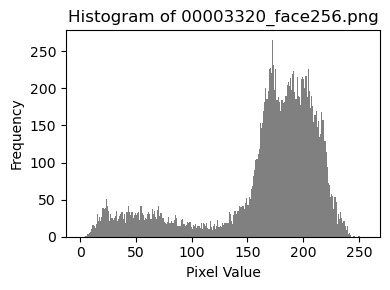

파일: 00003298_face3174.png
평균: 152.44, 표준편차: 52.82, 분산: 2790.15, 엔트로피: 7.59


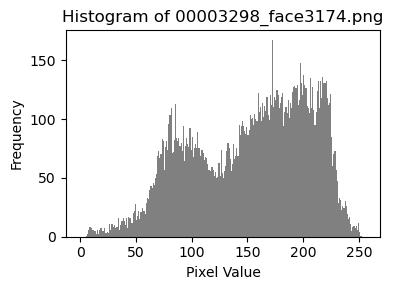

파일: 00000719_face2379.png
평균: 122.36, 표준편차: 57.82, 분산: 3343.61, 엔트로피: 7.77


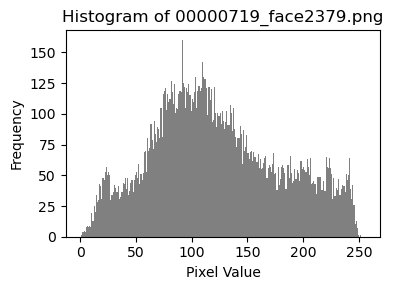

파일: 00003369_face983.png
평균: 62.00, 표준편차: 41.55, 분산: 1726.27, 엔트로피: 7.14


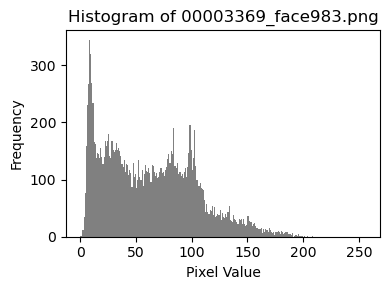

파일: 00000569_face2601.png
평균: 171.89, 표준편차: 73.90, 분산: 5460.96, 엔트로피: 7.56


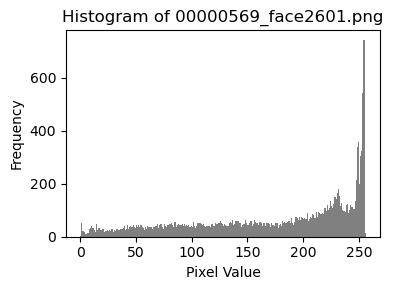

파일: 00000661_face843.png
평균: 72.16, 표준편차: 58.71, 분산: 3446.52, 엔트로피: 7.11


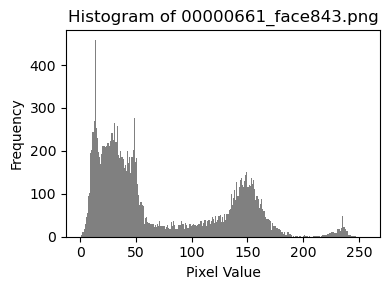

파일: 00001275_face2964.png
평균: 88.27, 표준편차: 64.51, 분산: 4161.76, 엔트로피: 7.22


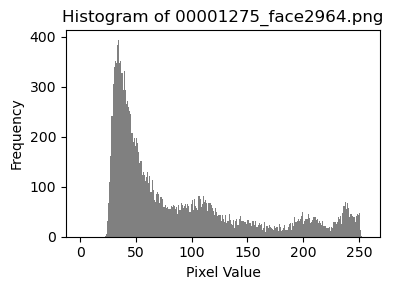

파일: 00000008_face3167.png
평균: 170.90, 표준편차: 60.74, 분산: 3689.45, 엔트로피: 6.68


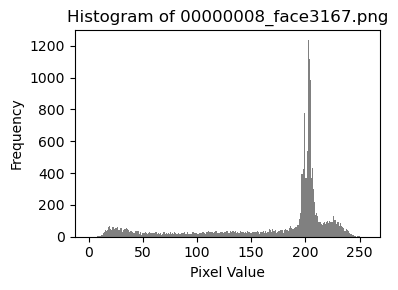

파일: 00001048_face3129.png
평균: 99.11, 표준편차: 45.81, 분산: 2098.87, 엔트로피: 7.29


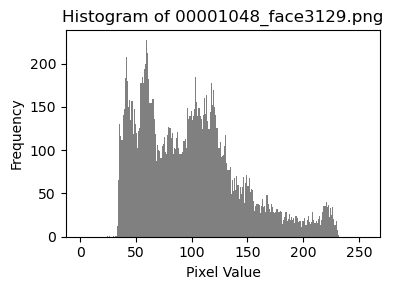

파일: 00001050_face2.png
평균: 72.59, 표준편차: 57.20, 분산: 3271.69, 엔트로피: 7.40


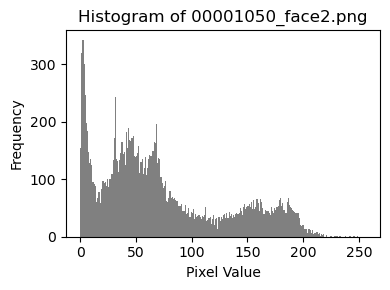

In [ ]:
import cv2, os, random
import numpy as np
import matplotlib.pyplot as plt


def cal_entropy(image):
    hist = cv2.calcHist([image], [0], None, [256], [0, 256])
    hist_norm = hist.ravel() / hist.sum()
    hist_norm = hist_norm[hist_norm > 0]
    entropy = -np.sum(hist_norm * np.log2(hist_norm))
    return entropy

# 이미지 폴더 경로
folder_path = "./processed2"
image_files = [f for f in  os.listdir(folder_path) if f.endswith(('.jpg', '.png', '.jpeg'))]

max_sample = 10
sample_files = random.sample(image_files, min(max_sample, len(image_files)))


# 반복처리
for file in sample_files:
    file_path = os.path.join(folder_path, file)
    img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
    
    if img is None:
        print(f"❌ 이미지 로드 실패: {file}")
        continue
    
    # 수치 분석
    mean_val = np.mean(img)
    std_val = np.std(img)
    var_val = np.var(img)
    entropy_val = cal_entropy(img)
    
    print(f"파일: {file}")
    print(f"평균: {mean_val:.2f}, 표준편차: {std_val:.2f}, 분산: {var_val:.2f}, 엔트로피: {entropy_val:.2f}")
    
    # 시각화
    plt.figure(figsize=(4,3))
    plt.hist(img.ravel(), bins=256, range=[0, 256], color='gray')
    plt.title(f"Histogram of {file}")   
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')
    plt.tight_layout()
    # plt.savefig(f"./histograms/{file}_histogram.png")
    plt.show()